In [1]:
import numpy as np

import scipy.constants as cs
from scipy.optimize import curve_fit
import scipy.ndimage as ndimage
from ImageProcessing import *

import matplotlib.pyplot as plt
import matplotlib.scale as scale

import tqdm
import scipy.io

import csv

In [2]:
data = scipy.io.loadmat('real data/jun1_run9.mat')
stack = data['stack']

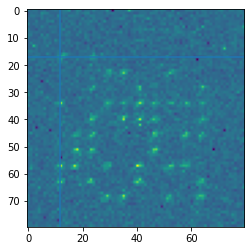

In [3]:
plt.imshow(stack[1])
plt.axvline(11.77)
plt.axhline(17.032)

20


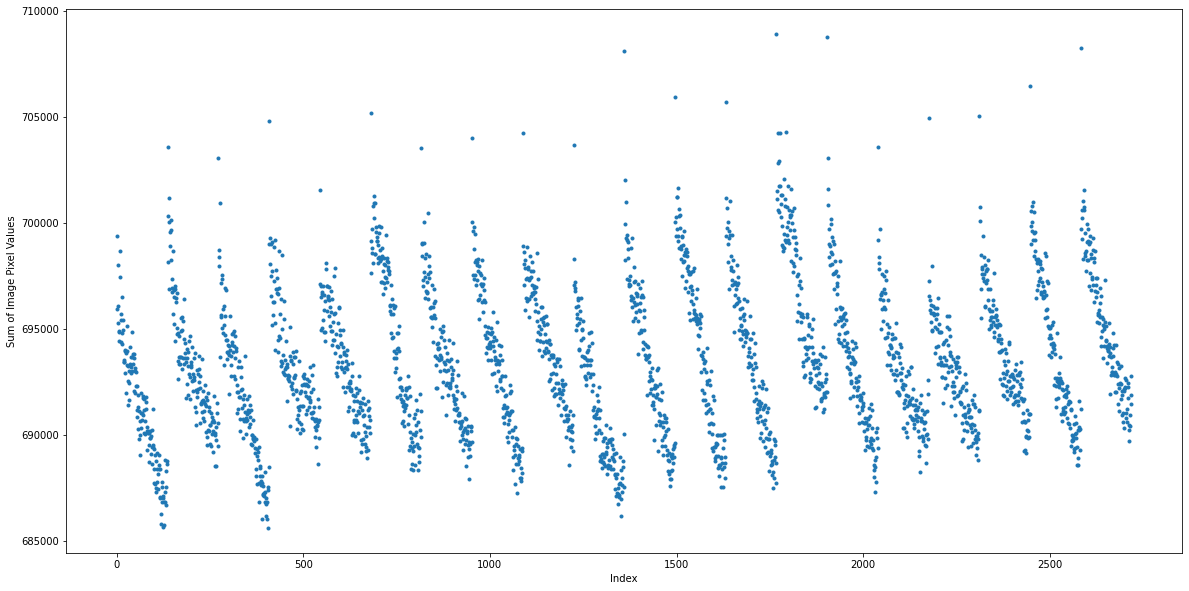

In [4]:
pixels = np.sum(stack, axis=(1, 2))
n_per_loop = 136
n_loops = stack.shape[0] // n_per_loop

print(n_loops)

plt.figure(figsize=(20, 10))
plt.plot(pixels, '.')
#for i in range(20):
#    plt.axvline(136 * i, color='r', linestyle='--')

plt.xlabel("Index")
plt.ylabel("Sum of Image Pixel Values")
plt.show()

Seems that every 136 images we reset the lattice.

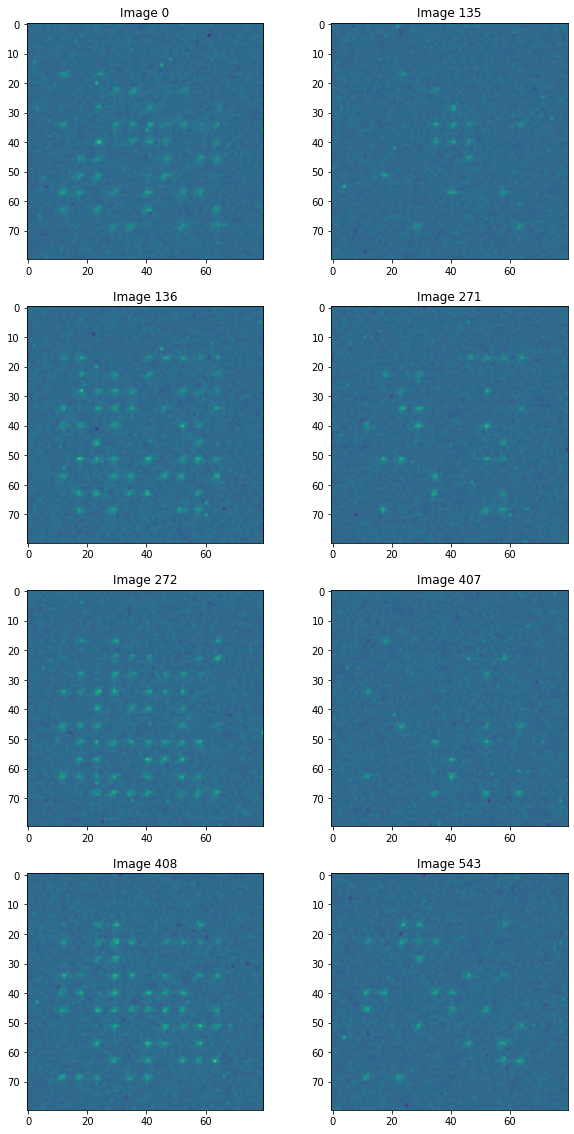

In [5]:
fig, axs = plt.subplots(4, 2, figsize=(10, 20))
min_val, max_val = stack.min(), stack.max()

for i in range(4):
    axs[i, 0].imshow(stack[136 * i], vmin=min_val, vmax=max_val)
    axs[i, 1].imshow(stack[136 * (i + 1) - 1], vmin=min_val, vmax=max_val)
    axs[i, 0].set_title(f"Image {136 * i}")
    axs[i, 1].set_title(f"Image {136 * (i + 1) - 1}")

(14, 0)


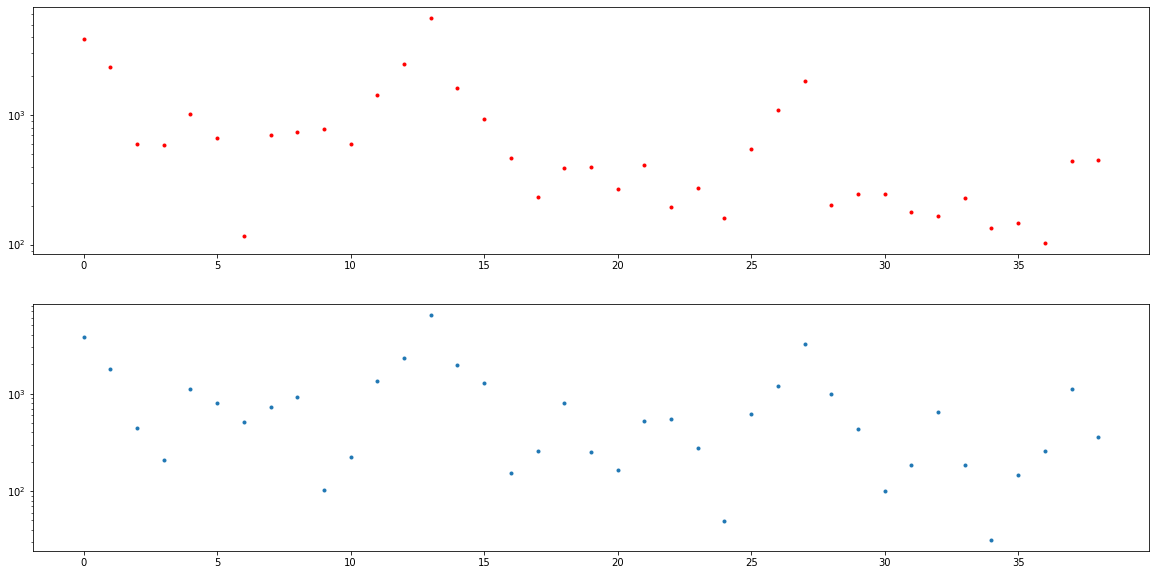

In [6]:
avg_img = np.mean(stack, axis=0) - np.mean(stack)
spectral_content = np.fft.fft2(avg_img)
spectral_content = spectral_content[:spectral_content.shape[0] // 2, :spectral_content.shape[1] // 2]

print(np.unravel_index(spectral_content.argmax(), spectral_content.shape))

fig, axs = plt.subplots(2, 1, figsize=(20, 10))

axs[0].plot(np.absolute(spectral_content[0, 1:]), 'r.')
axs[0].set_yscale('log')
axs[1].plot(np.absolute(spectral_content[1:, 0]), '.')
axs[1].set_yscale('log')

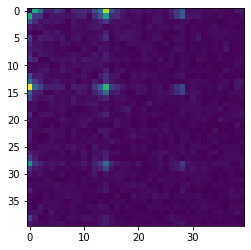

6413.514809855284


In [7]:
plt.imshow(np.absolute(spectral_content))
plt.show()

print(np.absolute(spectral_content[14, 0]))

In [8]:
a0, a1, lattice_offset = lattice_characteristics_rect(stack, np.array([10, 10]))
#background_statistics(stack, np.array([10, 10]), lattice_constant, lattice_offset)
print(lattice_offset.shape)
images = crop_sites(3, stack, a0, a1, lattice_offset, np.array([10, 10]))
print(images.shape)
images = np.reshape(images, (100, -1, 18, 18))

i = np.random.randint(0, images.shape[0])
j = np.random.randint(0, images.shape[1])

fig, axs = plt.subplots(1, 4, figsize=(20, 10))
combined = np.concatenate((images[i, j], images[i, j + 3]))
min_val, max_val = combined.min(), combined.max()

for n in range(4):
    axs[n].imshow(images[i, j + n], vmin=min_val, vmax=max_val)
plt.show()

NameError: name 'lattice_characteristics_rect' is not defined

In [ ]:
images = crop_sites(1, stack, a0, a1, lattice_offset, np.array([10, 10]))
images = np.reshape(images, (100, -1, 6, 6))
print(images.shape)

NameError: name 'crop_sites' is not defined

# Single Site Aggregate Pixels -- Red Lines Mark New Loop

In [ ]:
i = np.random.randint(0, images.shape[0])

plt.figure(figsize=(20, 10))
plt.plot(np.mean(images[i], axis=(1, 2)), '.')
for i in range(20):
    plt.axvline(136 * i, color='r', linestyle='--')

NameError: name 'images' is not defined

In [11]:
img = LatticeImage(stack, np.array([10, 10]), 20)
crops, labels = img.process()
print(crops.shape)



(272000, 16, 16)
